In [ ]:
!pip install --upgrade gdown   # update gdown
!gdown 14pf06S_6lalxmNW_bIgClXvki7Oqfnwi  # Download database images
!gdown 1BhbQlsHiztZrYbq9ApcuLpTaFYn8a5cq # Download detection model
!gdown 1FiWVKqFM0E0EnlmrjwS1ldJoufjd0Ziv # Download features model

In [ ]:
!unzip imgs_db.zip # unzip imgs_db
!unzip /content/detection.zip
!mkdir /content/image_retrieval

!mv  /content/detection  /content/image_retrieval       # rename folder img to imgs_db
!mv -T /content/img  /content/image_retrieval/imgs_db   # rename folder img to imgs_db
!mkdir /content/image_retrieval/test_case
!mkdir /content/image_retrieval/test_case/inp
!mkdir /content/image_retrieval/test_case/out
!wget https://www.dmarge.com/wp-content/uploads/2021/01/dwayne-the-rock-.jpg -P /content/image_retrieval/test_case/inp
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/800px-Cat03.jpg -P /content/image_retrieval/test_case/inp

!rm -rf /content/imgs_db.zip
!rm -rf /content/detection.zip

In [1]:
%cd /content/image_retrieval

/content/image_retrieval


In [2]:
import sys 
sys.path.insert(0, "/content/image_retrieval/detection/yolov5")

from detection.detector import YOLO
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
class SearchEngine:
    def __init__(self, model, dir_images, p_src_features):
        if model == "yolov5":
            self.model = YOLO("/content/image_retrieval/detection/weights/yolov5s.pt")

        if p_src_features is None or not os.path.exists(p_src_features):
            self.db_extract_features(dir_images, p_src_features)
        db = np.load(p_src_features)
        self.path_imgs = db["p_imgs"]
        self.src_features = db["features"]   
    
    def load_img(self, img):
        if isinstance(img, str):
            img = cv2.imread(img)
        return img
        
    def preprocess(self, img):
        img = self.load_img(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img

    # Extract feature from image
    def extractor(self, img):
        img = self.preprocess(img)
        boxes, scores, clss = self.model.predict(img)
        feature = np.zeros((80, ), dtype=np.int32)
        if len(clss) <= 0:
            return feature[None, :]
        clss_unique = np.unique(clss.astype(int))
        feature[clss_unique] = 1
        return feature[None, :]
    
    def search(self, query_img, display=True, top=30):
        dest_feature = self.extractor(query_img)
        scores = (dest_feature @ self.src_features.T)[0]
        idxs_max = np.argsort(scores)[::-1][:top]
        if display:
            self.display(self.path_imgs[idxs_max])

        return list(zip(scores[idxs_max], self.path_imgs[idxs_max]))

    # Display result
    def display(self, paths, columns = 5, rows = 6):
        fig = plt.figure(figsize=(15, 15))
        for i, path in enumerate(paths):
            fig.add_subplot(rows, columns, i + 1)
            plt.imshow(plt.imread(path))
            plt.axis("off")
        plt.show()

    # Extract database images to features
    def db_extract_features(self, dir_images, p_src_features):
        path_imgs = []
        features = []
        for dir_cls in tqdm(os.listdir(dir_images)):
            for idx, name_img in enumerate(os.listdir(f"{dir_images}/{dir_cls}")):
                try:
                    p_img = f"{dir_images}/{dir_cls}/{name_img}"
                    feature = self.extractor(p_img)
                    features.extend(feature)
                    path_imgs.append(p_img)
                except:
                    print("error:", p_img)

        path_imgs = np.array(path_imgs)
        features = np.array(features)

        np.savez(p_src_features, p_imgs=path_imgs, features=features)

In [4]:
dir_images="/content/image_retrieval/imgs_db"
p_src_features="/content/image_retrieval/80_features_db.npz"
model="yolov5"
search_engine = SearchEngine(model=model, dir_images=dir_images, p_src_features=p_src_features)

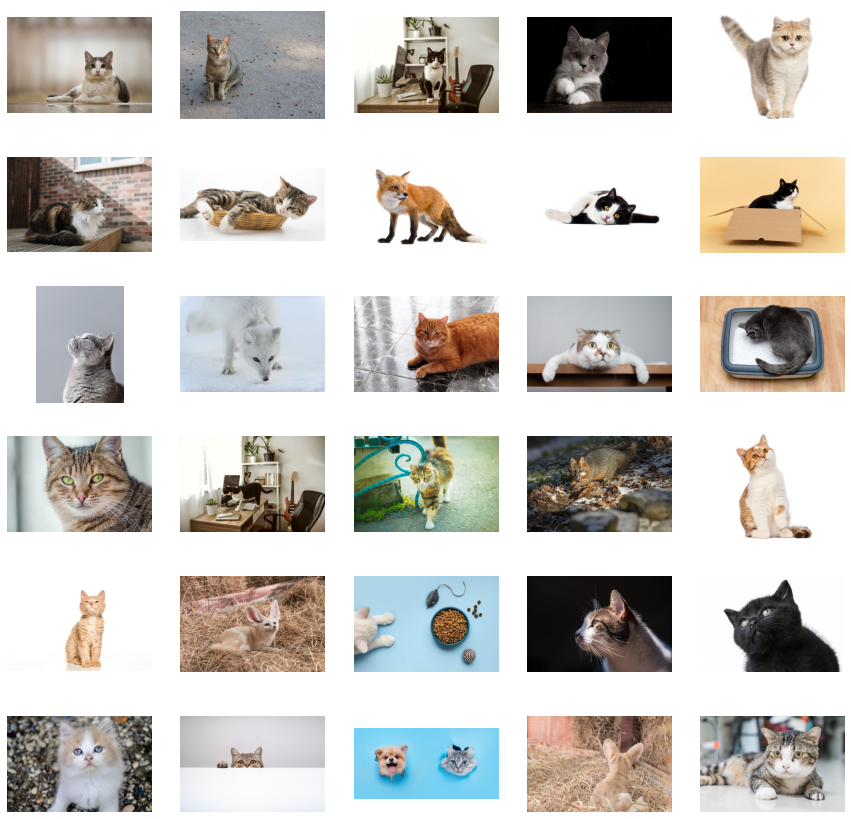

[(1, '/content/image_retrieval/imgs_db/animal_Cat/0.7658480391257148.jpg'),
 (1, '/content/image_retrieval/imgs_db/animal_Cat/0.6179361803081467.jpg'),
 (1, '/content/image_retrieval/imgs_db/animal_Cat/0.43528955268133396.jpg'),
 (1, '/content/image_retrieval/imgs_db/animal_Cat/0.9835193149633791.jpg'),
 (1, '/content/image_retrieval/imgs_db/animal_Cat/0.8169363140814755.jpg'),
 (1, '/content/image_retrieval/imgs_db/animal_Cat/0.04859980700044497.jpg'),
 (1, '/content/image_retrieval/imgs_db/animal_Cat/0.06829488435540676.jpg'),
 (1, '/content/image_retrieval/imgs_db/animal_fox/0.7786599859361392.jpg'),
 (1, '/content/image_retrieval/imgs_db/animal_Cat/0.6429256476968039.jpg'),
 (1, '/content/image_retrieval/imgs_db/animal_Cat/0.1709569939867227.jpg'),
 (1, '/content/image_retrieval/imgs_db/animal_Cat/0.701249155898456.jpg'),
 (1, '/content/image_retrieval/imgs_db/animal_fox/0.7907239542022763.jpg'),
 (1, '/content/image_retrieval/imgs_db/animal_Cat/0.7227999495269972.jpg'),
 (1, '/con

In [7]:
%matplotlib inline
p_query = "/content/image_retrieval/test_case/inp/800px-Cat03.jpg"
search_engine.search(p_query)

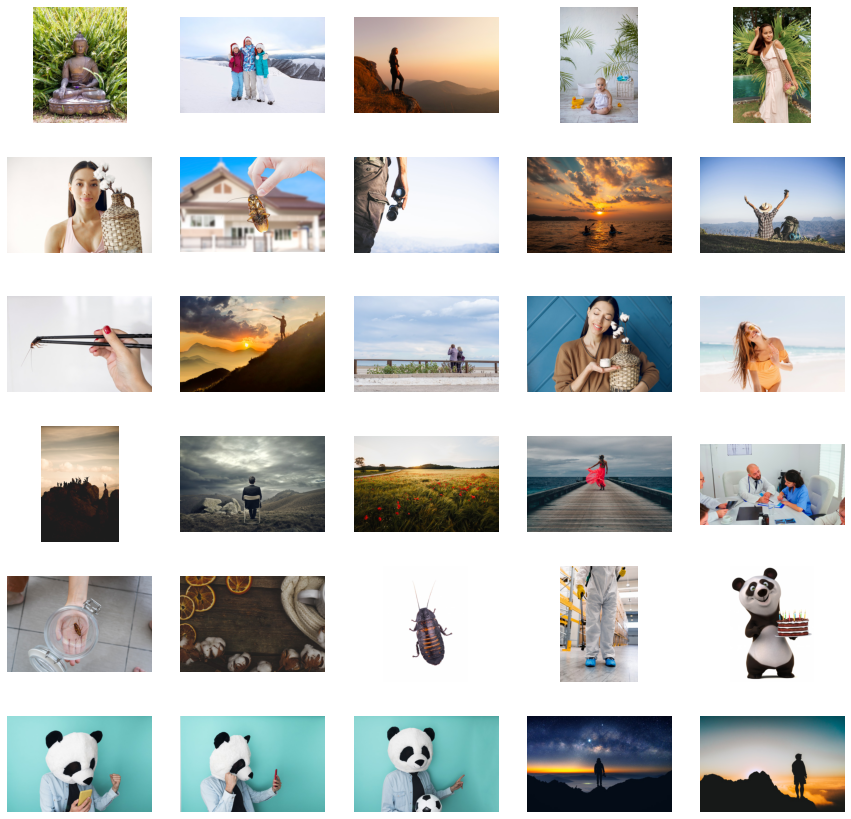

[(1, '/content/image_retrieval/imgs_db/plant_Fern/0.14128756428334843.jpg'),
 (1, '/content/image_retrieval/imgs_db/scenery_horizon/0.717003272781327.jpg'),
 (1,
  '/content/image_retrieval/imgs_db/scenery_horizon/0.7917005549209504.jpg'),
 (1,
  '/content/image_retrieval/imgs_db/plant_CottonPlant/0.5794523960250852.jpg'),
 (1,
  '/content/image_retrieval/imgs_db/plant_CottonPlant/0.5810550612187881.jpg'),
 (1,
  '/content/image_retrieval/imgs_db/plant_CottonPlant/0.05427702298361936.jpg'),
 (1,
  '/content/image_retrieval/imgs_db/animal_Cockroaches/0.7921408296194568.jpg'),
 (1,
  '/content/image_retrieval/imgs_db/scenery_horizon/0.8015760269294216.jpg'),
 (1,
  '/content/image_retrieval/imgs_db/scenery_horizon/0.42186753788460774.jpg'),
 (1,
  '/content/image_retrieval/imgs_db/scenery_horizon/0.24938236176975292.jpg'),
 (1,
  '/content/image_retrieval/imgs_db/animal_Cockroaches/0.6373998561228212.jpg'),
 (1,
  '/content/image_retrieval/imgs_db/scenery_horizon/0.37530288587858585.jpg'

In [8]:
%matplotlib inline
p_query = "/content/image_retrieval/test_case/inp/dwayne-the-rock-.jpg"
search_engine.search(p_query)